# import libs

In [1]:
import ast
import pandas as pd
import numpy as np
from sklearn import preprocessing

from pandas_gbq import read_gbq , to_gbq
import time
import hashlib

import json

In [2]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

In [3]:
import plotly.express as px


# load data

In [16]:
df_eventlog = pd.read_csv('./data/real_gdp_to_deltadna_v2.csv')

df_eventlog = df_eventlog[['eventName','sessionID','eventTimestamp']]
df_eventlog.head(2)

,eventName,sessionID,eventTimestamp
0,sensor,5bd3bfd7-c36c-4b55-b773-4004c31b3e1c,2020-11-19 13:24:36.332000
1,sensor,5bd3bfd7-c36c-4b55-b773-4004c31b3e1c,2020-11-19 13:24:36.331000


# preprocess data

In [17]:
df_eventlog.rename(columns={'eventTimestamp': 'time:timestamp'}, inplace=True)
df_eventlog.rename(columns={'sessionID': 'case:visitid'}, inplace=True)


In [18]:
le = preprocessing.LabelEncoder()
le.fit(df_eventlog['case:visitid'])
df_eventlog['case:concept:name'] = le.transform(df_eventlog['case:visitid'])
df_eventlog.rename(columns={'eventName': 'concept:name'}, inplace=True)


df_eventlog = dataframe_utils.convert_timestamp_columns_in_df(df_eventlog)

df_eventlog = df_eventlog.sort_values('time:timestamp')

print(df_eventlog.shape)

df_eventlog.head(5)

(35057, 4)


,concept:name,case:visitid,time:timestamp,case:concept:name
35056,newPlayer,523f8a96-df50-4765-bdb7-cbd1160fc51a,2020-10-21 14:16:50.933000+00:00,98
35055,gameStarted,523f8a96-df50-4765-bdb7-cbd1160fc51a,2020-10-21 14:16:50.937000+00:00,98
35054,clientDevice,523f8a96-df50-4765-bdb7-cbd1160fc51a,2020-10-21 14:16:50.940000+00:00,98
35053,gameStarted,b93d325c-99a6-42a7-a74c-34cc55498ed7,2020-10-21 14:23:19.907000+00:00,213
35052,clientDevice,b93d325c-99a6-42a7-a74c-34cc55498ed7,2020-10-21 14:23:19.914000+00:00,213


In [19]:
event_log = log_converter.apply(df_eventlog)


# make process mining
проведем анализ process mining для определения основных флоу евентов

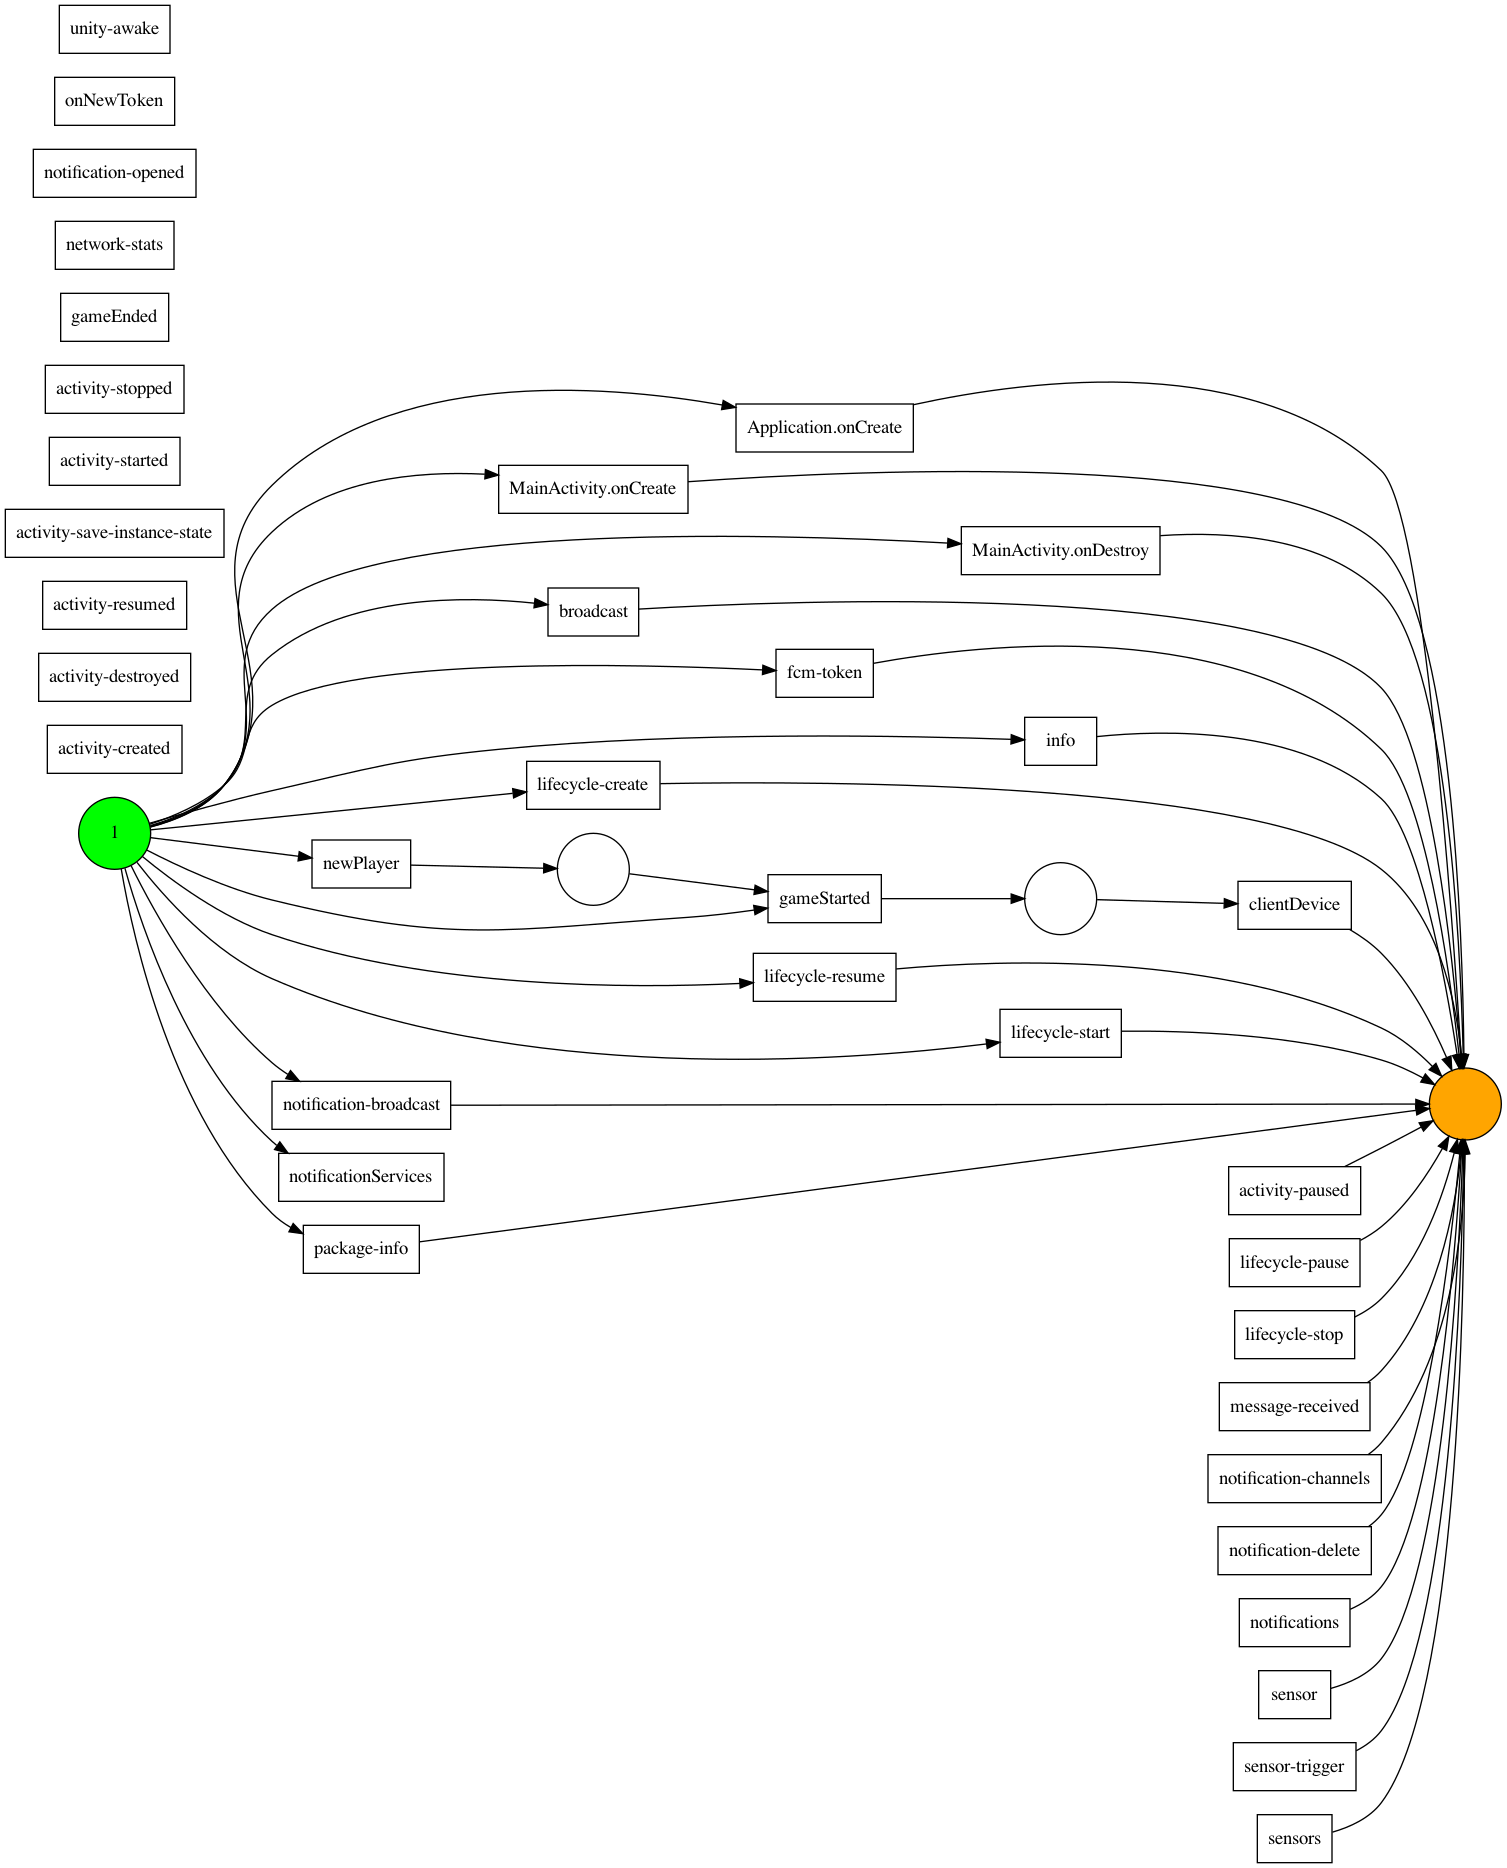

In [20]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(event_log)

# viz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)



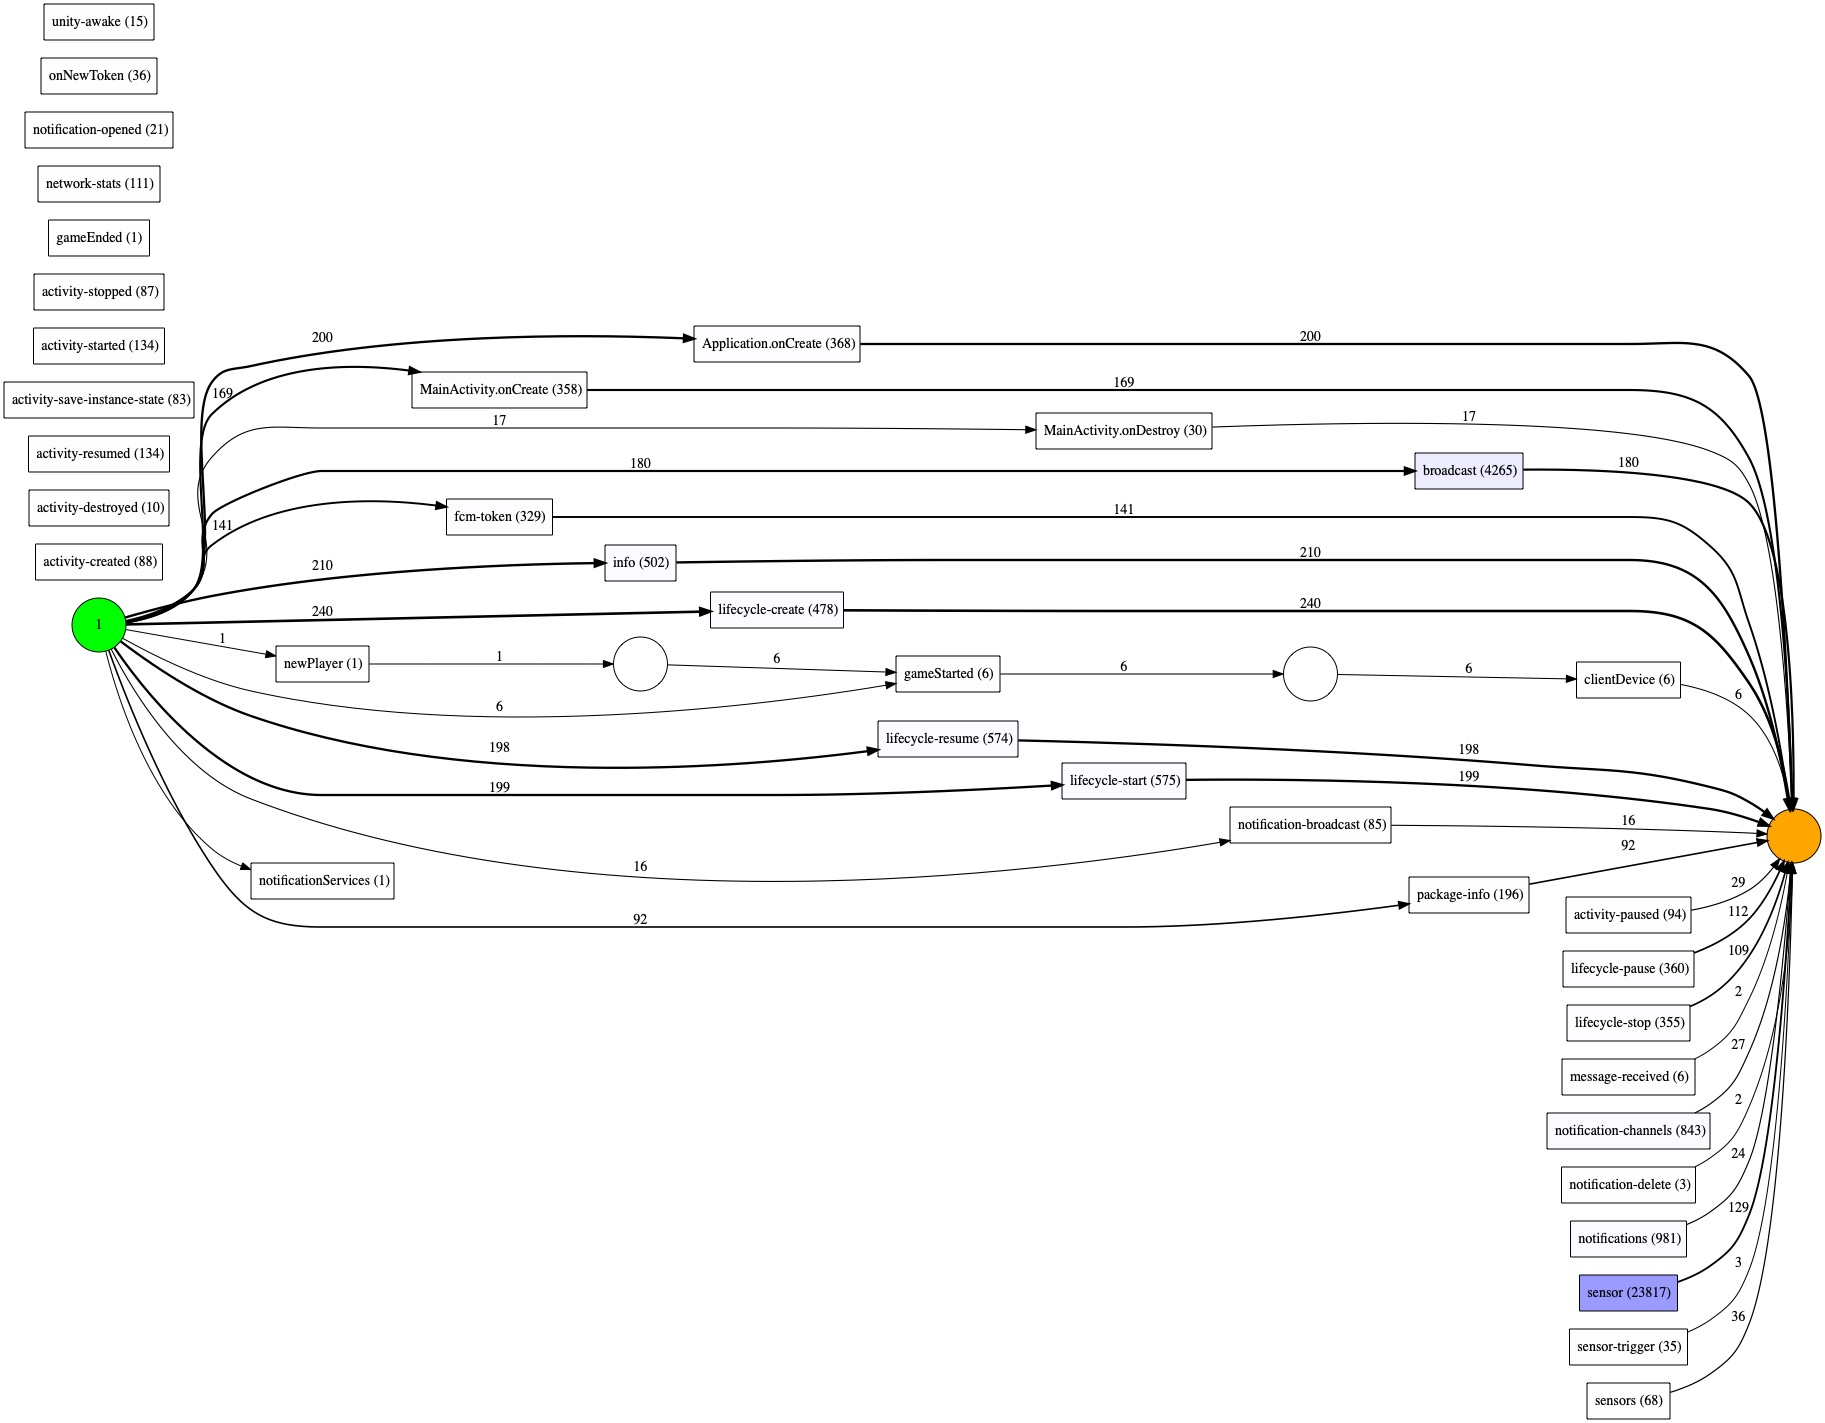

In [21]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "jpg"}

gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=event_log)

# save the Petri net
pn_visualizer.view(gviz)
pn_visualizer.save(gviz, "./process_mining/alpha_miner.jpg")

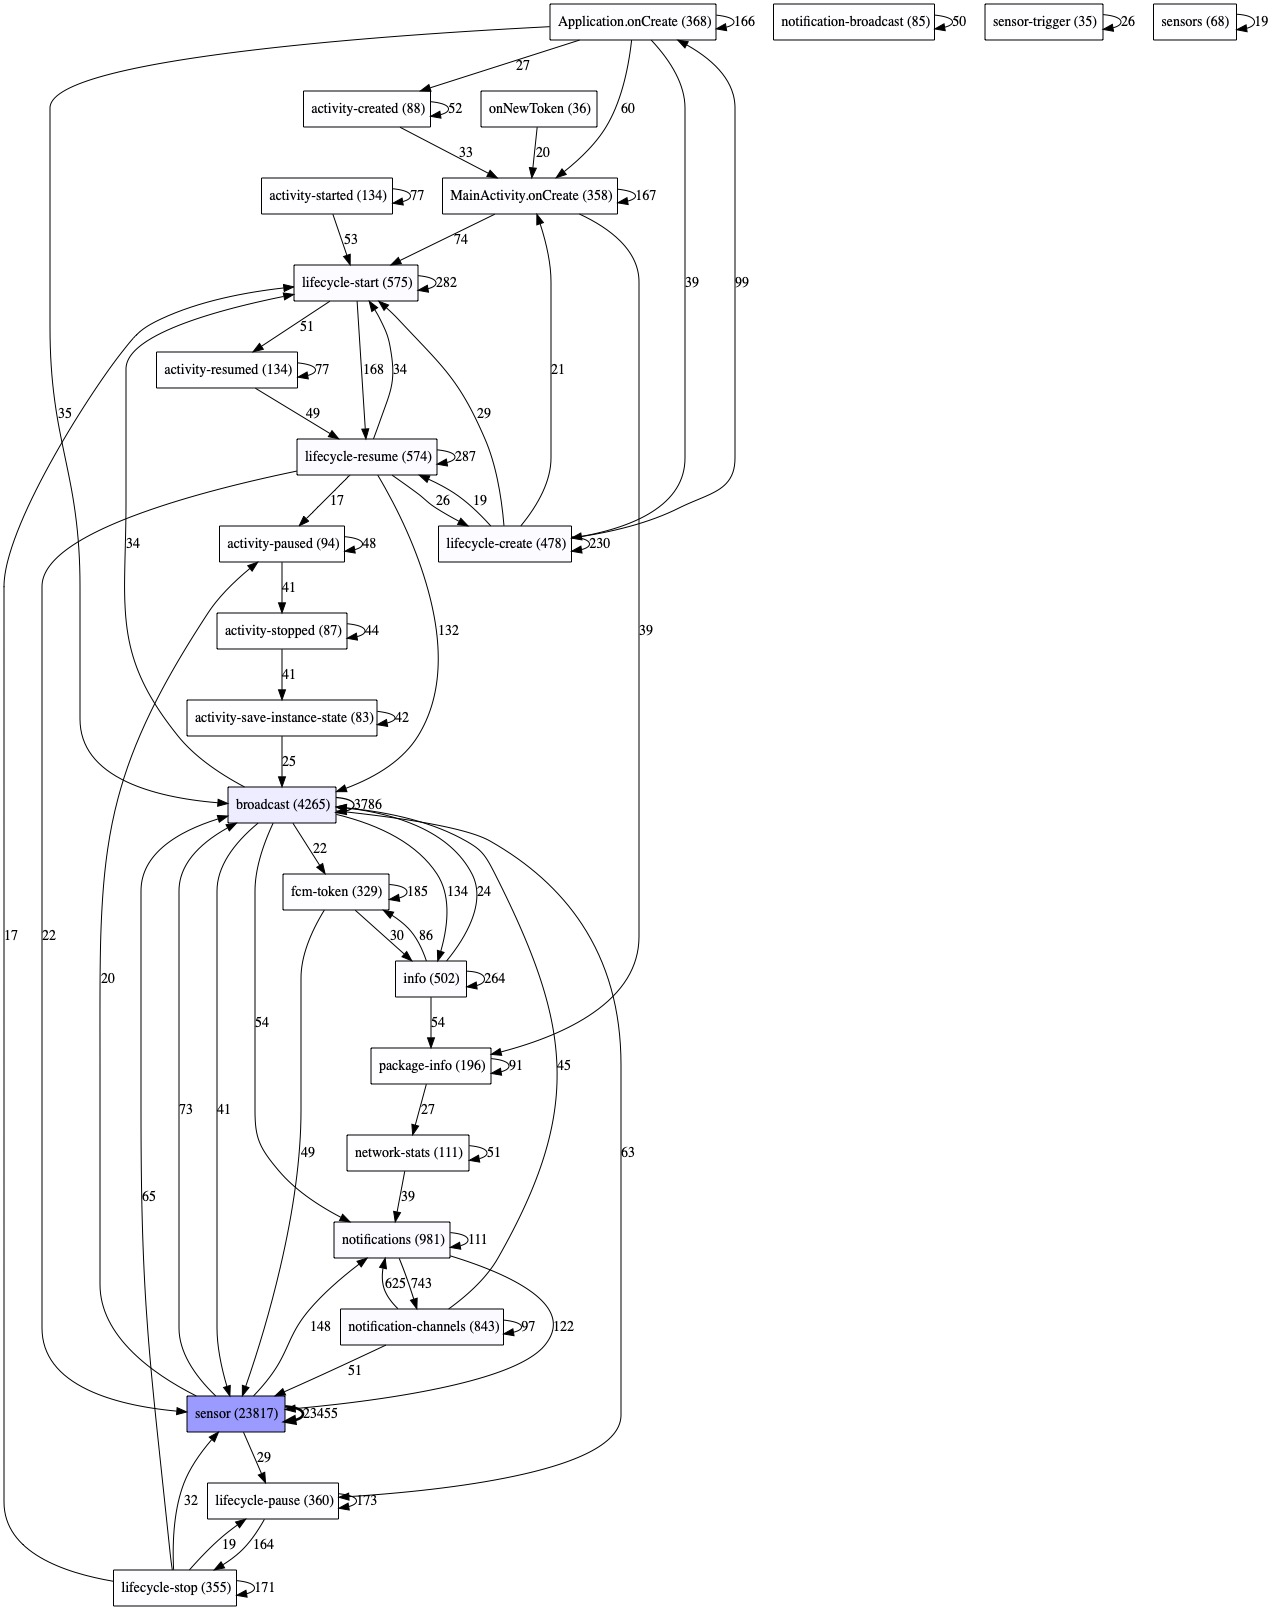

In [22]:
#PERFORMANCE - покажет среднее время перехода между состояниями
#FREQUENCY - подсветит частоту

dfg = dfg_discovery.apply(event_log, variant=dfg_discovery.Variants.FREQUENCY)
parameters = {dfg_visualization.Variants.FREQUENCY.value.Parameters.FORMAT: "jpg"}
gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)

dfg_visualization.view(gviz)

dfg_visualization.save(gviz, "./process_mining/dfg_miner.jpg")

# Explore analysis
Проанализируем информацию в основных действиях

Последовательность значимых шагов:
    - lifecycle-create
    - Application.onCreate
    - MainActivity.onCreate
    - MainActivity.onDestroy
    - notification-broadcast
    - sensor-trigger
    - info
    - sensor-changed

In [46]:
#уникальные евенты
df_eventlog['concept:name'].unique()

array(['onCreate', 'info', 'notification-broadcast', 'fcm-token',
       'Application.onCreate', 'MainActivity.onCreate',
       'MainActivity.onDestroy', 'notification-opened',
       'onAppBackgrounded', 'onAppForegrounded', 'lifecycle-create',
       'lifecycle-start', 'lifecycle-resume', 'lifecycle-pause',
       'lifecycle-stop', 'sensor-changed', 'sensor-trigger', 'sensors'],
      dtype=object)

In [50]:
df_eventlog[(df_eventlog['concept:name'] == 'lifecycle-create')][['data']].sample(5)

,data
311,{}
724,{}
706,{}
691,{}
310,{}


In [51]:
df_eventlog[(df_eventlog['concept:name'] == 'Application.onCreate')][['data']].sample(5)

,data
858,{}
754,{}
817,{}
847,{}
764,{}


In [52]:
df_eventlog[(df_eventlog['concept:name'] == 'MainActivity.onCreate')][['data']].sample(5)

,data
803,{}
835,{}
689,{}
839,{}
831,{}


In [53]:
df_eventlog[(df_eventlog['concept:name'] == 'MainActivity.onDestroy')][['data']].sample(5)

,data
836,{}
755,{}
707,{}
818,{}
742,{}


In [54]:
df_eventlog[(df_eventlog['concept:name'] == 'notification-broadcast')][['data']].sample(5)

,data
822,"{""action"": ""android.intent.action.SCREEN_OFF""}"
823,"{""action"": ""android.intent.action.SCREEN_ON""}"
756,"{""action"": ""android.intent.action.SCREEN_ON""}"
738,"{""action"": ""ai.gosu.dataplatform.NOTIFICATION_..."
862,"{""action"": ""android.intent.action.SCREEN_OFF""}"


In [55]:
df_eventlog[(df_eventlog['concept:name'] == 'sensor-trigger')][['data']].sample(5)

,data
48,"{""sensor"": ""stationary_detect"", ""values"": [1]}"
109,"{""sensor"": ""stationary_detect"", ""values"": [1]}"
56,"{""sensor"": ""stationary_detect"", ""values"": [1]}"
229,"{""sensor"": ""stationary_detect"", ""values"": [1]}"
136,"{""sensor"": ""stationary_detect"", ""values"": [1]}"


In [56]:
df_eventlog[(df_eventlog['concept:name'] == 'info')][['data']].sample(5)

,data
254,"{""name"": ""MI CC9 Pro"", ""model"": ""MI CC9 Pro"", ..."
746,"{""BOARD"": ""tucana"", ""deviceName"": ""MI CC9 Pro""..."
781,"{""BOARD"": ""tucana"", ""deviceName"": ""MI CC9 Pro""..."
257,"{""name"": ""MI CC9 Pro"", ""model"": ""MI CC9 Pro"", ..."
304,"{""eventParameters"": ""{\""name\"":\""MI CC9 Pro\"",..."


In [57]:
df_eventlog[(df_eventlog['concept:name'] == 'sensor-changed')][['data']].sample(5)

,data
332,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc..."
606,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc..."
456,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc..."
490,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc..."
503,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc..."


# Quality analysis
Какая-либо дополнительная информация содержиться в 4 типах евентов:
    - notification-broadcast
    - sensor-trigger
    - info
    - sensor-changed

## notification-broadcast

In [61]:
df_nb = df_eventlog[(df_eventlog['concept:name'] == 'notification-broadcast')][:]
df_nb.head(2)

,time:timestamp,concept:name,user,case:visitid,data,id,case:concept:name
873,2020-10-22 15:17:28.785000+00:00,notification-broadcast,7f2f9b8421376565,71986eef-3f1a-4d18-9be9-219f9933b9ae,"{""action"": ""android.intent.action.SCREEN_ON""}",NaN,15
872,2020-10-22 15:27:38.578000+00:00,notification-broadcast,7f2f9b8421376565,71986eef-3f1a-4d18-9be9-219f9933b9ae,"{""action"": ""android.intent.action.SCREEN_OFF""}",NaN,15


In [62]:
#доля событий
print(f'доля событий {df_nb.shape[0] / df_eventlog.shape[0]}')


доля событий 0.08095781071835804


In [72]:

df_nb['data'] = df_nb['data'].apply(lambda x: ast.literal_eval(x))


In [83]:
data_df = pd.DataFrame(list(df_nb['data']))
data_df.head(2)

,action,eventParameters
0,android.intent.action.SCREEN_ON,NaN
1,android.intent.action.SCREEN_OFF,NaN


In [89]:
fig = px.histogram(data_df, x="action",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()
fig = px.histogram(data_df, x="eventParameters",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## sensor-trigger

In [90]:
df_nb = df_eventlog[(df_eventlog['concept:name'] == 'sensor-trigger')][:]
df_nb.head(2)

,time:timestamp,concept:name,user,case:visitid,data,id,case:concept:name
236,2020-10-23 14:52:55.577000+00:00,sensor-trigger,7f2f9b8421376565,6c39fd55-bac2-4a01-8ced-9873b6ae7a6b,"{""sensor"": ""stationary_detect"", ""values"": [1]}",a079cb63-e2f7-4cd1-aaab-e65673541a6d,14
235,2020-10-23 14:53:00.607000+00:00,sensor-trigger,7f2f9b8421376565,6c39fd55-bac2-4a01-8ced-9873b6ae7a6b,"{""sensor"": ""stationary_detect"", ""values"": [1]}",edb7ff59-cc6c-4805-a848-3697af6f9484,14


In [91]:
#доля событий
print(f'доля событий {df_nb.shape[0] / df_eventlog.shape[0]}')


доля событий 0.23717217787913342


In [92]:

df_nb['data'] = df_nb['data'].apply(lambda x: ast.literal_eval(x))


In [93]:
data_df = pd.DataFrame(list(df_nb['data']))
data_df.head(2)

,sensor,values
0,stationary_detect,[1]
1,stationary_detect,[1]


In [95]:
fig = px.histogram(data_df, x="sensor",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()
fig = px.histogram(data_df, x="values",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## info

In [96]:
df_nb = df_eventlog[(df_eventlog['concept:name'] == 'info')][:]
df_nb.head(2)

,time:timestamp,concept:name,user,case:visitid,data,id,case:concept:name
874,2020-10-22 15:17:28.404000+00:00,info,7f2f9b8421376565,71986eef-3f1a-4d18-9be9-219f9933b9ae,"{""BOARD"": ""tucana"", ""DISPLAY"": ""QKQ1.190825.00...",NaN,15
871,2020-10-22 15:30:44.692000+00:00,info,7f2f9b8421376565,71986eef-3f1a-4d18-9be9-219f9933b9ae,"{""BOARD"": ""tucana"", ""DISPLAY"": ""QKQ1.190825.00...",NaN,15


In [97]:
#доля событий
print(f'доля событий {df_nb.shape[0] / df_eventlog.shape[0]}')


доля событий 0.06271379703534778


In [98]:

df_nb['data'] = df_nb['data'].apply(lambda x: ast.literal_eval(x))


In [99]:
data_df = pd.DataFrame(list(df_nb['data']))
data_df.head(2)

,BOARD,DISPLAY,HARDWARE,PRODUCT,BOOTLOADER,ID,CPU_ABI,BRAND,deviceName,codename,name,timezoneName,timezoneId,model,timezoneOffset,eventParameters
0,tucana,QKQ1.190825.002 test-keys,qcom,tucana_eea,unknown,QKQ1.190825.002,arm64-v8a,Xiaomi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tucana,QKQ1.190825.002 test-keys,qcom,tucana_eea,unknown,QKQ1.190825.002,arm64-v8a,Xiaomi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
fig = px.histogram(data_df, x="BRAND",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()
fig = px.histogram(data_df, x="BOARD",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## sensor-changed

In [101]:
df_nb = df_eventlog[(df_eventlog['concept:name'] == 'sensor-changed')][:]
df_nb.head(2)

,time:timestamp,concept:name,user,case:visitid,data,id,case:concept:name
686,2020-10-23 13:15:39.295000+00:00,sensor-changed,7f2f9b8421376565,01d502d4-a596-495b-92ba-512e26b3e365,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc...",671069ed-ff08-4e82-8fd7-e9bb469c6e84,0
685,2020-10-23 13:15:39.299000+00:00,sensor-changed,7f2f9b8421376565,01d502d4-a596-495b-92ba-512e26b3e365,"{""eventParameters"": ""{\""sensor\"":\""lsm6dso Acc...",1fb34f31-cd22-46d4-b58f-e145934c718d,0


In [102]:
#доля событий
print(f'доля событий {df_nb.shape[0] / df_eventlog.shape[0]}')


доля событий 0.4823261117445838


In [103]:

df_nb['data'] = df_nb['data'].apply(lambda x: ast.literal_eval(x))


In [104]:
data_df = pd.DataFrame(list(df_nb['data']))
data_df.head(2)

,eventParameters,sensor,values,accuracy
0,"{""sensor"":""lsm6dso Accelerometer Non-wakeup"",""...",NaN,NaN,NaN
1,"{""sensor"":""lsm6dso Accelerometer Non-wakeup"",""...",NaN,NaN,NaN


In [110]:
data_df = data_df[~(data_df['eventParameters'].isnull())]
data_df['eventParameters'] = data_df['eventParameters'].apply(lambda x: ast.literal_eval(x))


data_df_2 = pd.DataFrame(list(data_df['eventParameters']))
data_df_2.head(2)

,sensor,values,accuracy
0,lsm6dso Accelerometer Non-wakeup,"[1.2534546, 5.592232, 8.055606]",3
1,lsm6dso Accelerometer Non-wakeup,"[1.2151489, 5.474921, 8.268682]",3


In [111]:
fig = px.histogram(data_df_2, x="sensor",
                 width=800, height=400)

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show()

fig.show()